In [1]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import spatial, interpolate
from scipy.stats import multivariate_normal
from scipy.interpolate import LSQUnivariateSpline
from scipy.interpolate import BSpline, make_interp_spline
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
import skfda
from skfda.preprocessing.dim_reduction.projection import FPCA
from skfda.representation.basis import BSpline, FDataBasis
from sklearn.model_selection import cross_val_score
from skfda.ml.regression import KNeighborsRegressor

In [3]:
from skfda.datasets import fetch_growth
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)

In [4]:
import scipy.interpolate as spi
import pywt
import scipy.fftpack as spfft
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

In [5]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

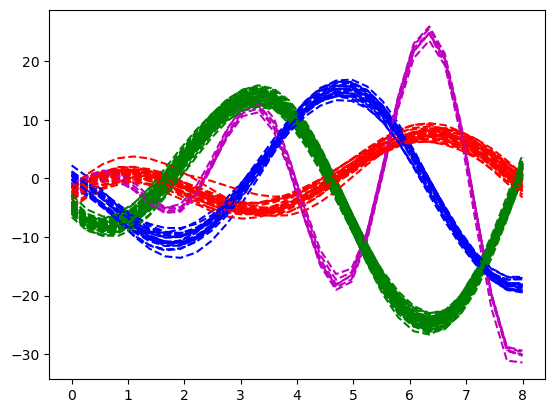

In [6]:
# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    # L2 distance (Squared Euclidian) where σ = 1
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

# Sample from the Gaussian process distribution
nb_of_samples = 30  # Number of points in each function
# Independent variable samples
t = np.expand_dims(np.linspace(0, 8, nb_of_samples), 1)
Σ = exponentiated_quadratic(t, t)  # Kernel of data points

# Create different curves
mean_curve = np.zeros((4, len(t)))
mean_curve[0] = np.reshape(-8*np.sin(t)*np.log(t+2), (nb_of_samples))
mean_curve[1] = np.reshape(4*np.cos(t)*np.log(t+0.5), (nb_of_samples))
mean_curve[2] = np.reshape(-2-4*np.cos(t)*(np.sqrt(5*t+0.5)), (nb_of_samples))
mean_curve[3] = np.reshape(5*np.cos(2*t)*np.log(t+0.5)*(np.sqrt(t+0.5)), (nb_of_samples))

mixture_k = [0.2, 0.2, 0.5, 0.1]
n = 100
Y = np.zeros((n, len(t)))
simulation_label = np.zeros(n)

for i in range(n):
    # generate a random number between 0 and 1
    r = np.random.rand()
    # find the index of the mixture component
    if r < mixture_k[0]:
        # draw for the first component
        ys = np.random.multivariate_normal(
        mean=mean_curve[0], cov=Σ, 
        size=1)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='b')
        # Remember the label of the component
        simulation_label[i] = 0

    elif r < mixture_k[0] + mixture_k[1]:
        # draw for the second component
        # draw for the first component
        ys = np.random.multivariate_normal(
        mean=mean_curve[1], cov=Σ, 
        size=1)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='r')
        # Remember the label of the component
        simulation_label[i] = 1
    
    elif r < mixture_k[0] + mixture_k[1] + mixture_k[2]:
        # draw for the first component
        ys = np.random.multivariate_normal(
        mean=mean_curve[2], cov=Σ, 
        size=1)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='g')
        # Remember the label of the component
        simulation_label[i] = 2

    else:
        # draw for the first component
        ys = np.random.multivariate_normal(
        mean=mean_curve[3], cov=Σ, 
        size=1)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='m')
        # Remember the label of the component
        simulation_label[i] = 3

In [7]:
Y.shape

(100, 30)

In [8]:
from smoother.gpmix_smoother import smoother

In [9]:
Smoother = smoother(smoother = 'bspline', smoother_args = {'degree': 3, 'n_basis': 10})
fdate_smoothed = Smoother.fit(Y)
fdate_smoothed.data_matrix.reshape(fdate_smoothed.n_samples, -1).shape

(100, 30)

In [10]:
from projector.gpmix_projector import projector

In [11]:
Projector = projector(projection_method = 'fpca', projection_args = {'basis': 'bspline', 'degree': 3, 'n_basis': 5, 'n_components': 4})
coefficients = Projector.fit(fdate_smoothed)
coefficients.shape

(100, 4)

In [12]:
from unigmm.gpmix_unigmm import unigmm

In [13]:
gmm = unigmm(n_components = 4)
gmms = gmm.fit(coefficients)

In [14]:
weights = gmm.calculate_weights()

In [15]:
from sklearn.cluster import SpectralClustering

In [16]:
sc = SpectralClustering(n_clusters=4, affinity='precomputed', assign_labels='discretize')
sc.fit(weights)
labels = sc.labels_

In [17]:
# Get the AMI score
from sklearn.metrics.cluster import adjusted_mutual_info_score
print("AMI score:")
print(adjusted_mutual_info_score(simulation_label, labels))

# Get the ARM score
from sklearn.metrics.cluster import adjusted_rand_score
print("ARM score:")
print(adjusted_rand_score(simulation_label, labels))

AMI score:
0.7268844657931439
ARM score:
0.6267573308852571
